# Lineages: Identifying boundaries between generations
Natalia Vélez, September 2020

The goal of this notebook is to identify when one generation ends and the next begins. These analyses will help us define time intervals for different community-level models (e.g., repertoire growth, population growth).

In [1]:
%matplotlib inline

import os,re,glob,scipy,json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from os.path import join as opj
from tqdm import notebook

from networkx.drawing.nx_agraph import graphviz_layout

sns.set_style('white')
sns.set_context('talk')

## Pick example families

Load family data:

In [2]:
fam_df = pd.read_csv('outputs/family_playerID.tsv', sep='\t', index_col=0)
fam_df.head()

/users/nvelezalicea/.conda/envs/py3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,avatar,family
0,3308592,time-1599460982_eve-3308568_name-SOL
1,3308568,time-1599460982_eve-3308568_name-SOL
2,3308504,time-1599458188_eve-3308504_name-SOL
3,3308439,time-1599456178_eve-3308427_name-MORALES
4,3308507,time-1599456178_eve-3308427_name-MORALES


Load lifelog data:

In [3]:
life_df = pd.read_csv('outputs/all_lifelogs_compact.tsv', sep='\t', index_col=0)
life_df = pd.merge(life_df, fam_df, on='avatar')
life_df.head()

/users/nvelezalicea/.conda/envs/py3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last,family
0,06d8ab86b0daf11b13a446b87f770aa20bee1ca0,3308603,1599462917,3308581,[-63752 -504],NaN,[],NaN,NaN,-63752,-504,NaN,NaN,SUPERIOR,MATSU,time-1599447278_eve-3308179_name-MATSU
1,67bffa53500e2c626edc407409b6550996b748db,3308602,1599462864,3308575,[-63753 -507],NaN,[],NaN,NaN,-63753,-507,NaN,NaN,FEATHER,MATSU,time-1599447278_eve-3308179_name-MATSU
2,fbc0168048713cfaf6ef6a350c0171e7b2b0af4a,3308601,1599462805,3308564,[-63762 -523],NaN,[],NaN,NaN,-63762,-523,NaN,NaN,SASHA,MATSU,time-1599447278_eve-3308179_name-MATSU
3,5d5050247e485d0224df4e392118c27b8ee3a88b,3308598,1599462667,3308575,[-63747 -498],NaN,[],NaN,NaN,-63747,-498,NaN,NaN,DRAGON,MATSU,time-1599447278_eve-3308179_name-MATSU
4,310d12780dbb316a3b50f83adbf9ce76973172bb,3308597,1599462620,3308571,[-63756 -508],1.599464e+09,[-63841 -520],28.89,hunger,-63756,-508,-63841.0,-520.0,MODOU,MATSU,time-1599447278_eve-3308179_name-MATSU


Load success df:

In [4]:
success_df = pd.read_csv('outputs/family_fitness.tsv', sep='\t')
success_df = success_df.sort_values(by='longest_path', ascending=False)
success_df = success_df.reset_index(drop=True)
success_df['log_gen'] = np.log10(success_df['longest_path'])

top_families = success_df.head(10)
top_families

,family,sum,count,a,b,beta_mean,beta_var,snr,weighted_size,longest_path,log_gen
0,time-1584155688_eve-2783193_name-JESUS,1678,2116,1681,441,0.792177,0.000078,10215.433107,1676.246937,238,2.376577
1,time-1582959703_eve-2742223_name-BELLUE,1362,1762,1365,403,0.772059,0.000099,7760.774194,1360.367647,234,2.369216
2,time-1579810712_eve-2612994_name-BOOTS,2178,2856,2181,681,0.762055,0.000063,12032.167401,2176.427673,234,2.369216
3,time-1592901881_eve-3098263_name-BATMAN,1423,1788,1426,368,0.794872,0.000091,8750.625000,1421.230769,205,2.311754
4,time-1579512354_eve-2600506_name-MEGALE,1410,1726,1413,319,0.815820,0.000087,9409.266458,1408.105081,187,2.271842
5,time-1581646981_eve-2692838_name-VOLTAIRE,1309,1685,1312,379,0.775872,0.000103,7549.266491,1307.344766,185,2.267172
6,time-1579967491_eve-2621464_name-EVA,1375,1869,1378,497,0.734933,0.000104,7077.464789,1373.590400,164,2.214844
7,time-1597380672_eve-3252200_name-KELL,932,1094,935,165,0.850000,0.000116,7340.000000,929.900000,163,2.212188
8,time-1584064999_eve-2780063_name-GOLD,1202,1498,1205,299,0.801197,0.000106,7570.301003,1200.192819,163,2.212188
9,time-1573313384_eve-2254999_name-SUGAR,627,789,630,165,0.792453,0.000207,3835.272727,625.245283,162,2.209515


Find quantiles of # generations:

In [5]:
log_q = scipy.stats.mstats.mquantiles(success_df['log_gen'], prob=[0.25, 0.5, 0.75, 1])
gen_q = [np.round(10**q) for q in log_q]
print(log_q)
print(gen_q)

[0.30103    0.69897    1.2787536  2.37657696]
[2.0, 5.0, 19.0, 238.0]


Plot quantiles:

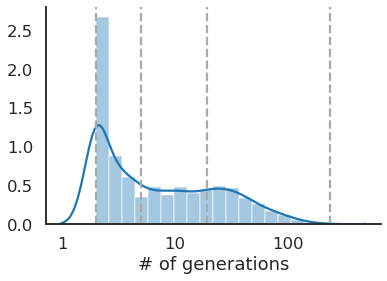

In [6]:
ax = sns.distplot(success_df['log_gen'])
ax.set(xticks = range(3), xticklabels = [10**x for x in range(3)],
       xlabel = '# of generations')

for q in log_q:
    plt.axvline(q, color='#aaaaaa', linestyle='--')
    
sns.despine()

Pick some middling families:

In [7]:
middle_families = success_df[(success_df['longest_path'] >= gen_q[1]) & (success_df['longest_path'] <= gen_q[2])]
print(middle_families.shape)

middle_sample = middle_families.head(10)
middle_sample

(1131, 11)


,family,sum,count,a,b,beta_mean,beta_var,snr,weighted_size,longest_path,log_gen
1023,time-1588091389_eve-2945499_name-LEBRASSEUR,176,249,179,76,0.701961,0.000817,858.947368,174.788235,19,1.278754
1024,time-1585603529_eve-2839846_name-LOGAN,65,107,68,45,0.601770,0.002102,286.266667,64.389381,19,1.278754
1025,time-1599079162_eve-3298182_name-UNO,106,127,109,24,0.819549,0.001104,742.583333,104.082707,19,1.278754
1026,time-1576303938_eve-2409702_name-LOVE,121,156,124,38,0.765432,0.001102,694.894737,119.407407,19,1.278754
1027,time-1577474166_eve-2476608_name-BRAZIL,70,97,73,30,0.708738,0.001985,357.066667,68.747573,19,1.278754
1028,time-1575807301_eve-2386784_name-KILIAN,58,75,61,20,0.753086,0.002268,332.100000,56.481481,19,1.278754
1029,time-1588217836_eve-2950091_name-DEBOARD,106,141,109,38,0.741497,0.001295,572.526316,104.551020,19,1.278754
1030,time-1577732570_eve-2494971_name-BATMAN,119,168,122,52,0.701149,0.001197,585.576923,117.793103,19,1.278754
1031,time-1577463206_eve-2475865_name-WASSER,84,110,87,29,0.750000,0.001603,468.000000,82.500000,19,1.278754
1032,time-1575845942_eve-2389247_name-LONGSTAFF,72,101,75,32,0.700935,0.001941,361.125000,70.794393,19,1.278754


Now we have the families that we're going to use as an example!

In [8]:
sample_families = middle_sample['family'].to_list()
print(*sample_families, sep='\n')

time-1588091389_eve-2945499_name-LEBRASSEUR
time-1585603529_eve-2839846_name-LOGAN
time-1599079162_eve-3298182_name-UNO
time-1576303938_eve-2409702_name-LOVE
time-1577474166_eve-2476608_name-BRAZIL
time-1575807301_eve-2386784_name-KILIAN
time-1588217836_eve-2950091_name-DEBOARD
time-1577732570_eve-2494971_name-BATMAN
time-1577463206_eve-2475865_name-WASSER
time-1575845942_eve-2389247_name-LONGSTAFF


Lifelog data from sample families:

In [9]:
sample_lifelogs = life_df[life_df['family'].isin(sample_families)]
sample_lifelogs = sample_lifelogs.reset_index(drop=True)
print(sample_lifelogs.shape)
sample_lifelogs.head()

(1435, 16)


,player,avatar,tBirth,parent,birth,tDeath,death,age,cause_of_death,birthX,birthY,deathX,deathY,first,last,family
0,3e8b3e994f0bf2cce1f1b8a745642ab19cd6f63c,3298921,1599107110,3298860,[-63266 -38],1.599108e+09,[-63263 -39],7.00,hunger,-63266,-38,-63263.0,-39.0,SAMMY,UNO,time-1599079162_eve-3298182_name-UNO
1,3e8b3e994f0bf2cce1f1b8a745642ab19cd6f63c,3298906,1599106511,3298860,[-63287 -42],1.599107e+09,[-63265 -39],8.57,hunger,-63287,-42,-63265.0,-39.0,ALLY,UNO,time-1599079162_eve-3298182_name-UNO
2,609999b8b69dea83b2b1cbf8f375988d56a37104,3298893,1599106012,3298827,[-63266 -35],1.599106e+09,[-63229 -116],7.01,hunger,-63266,-35,-63229.0,-116.0,GONZALA,UNO,time-1599079162_eve-3298182_name-UNO
3,5068f3f0788cdcd03842fb28b1e3f1ef56c6cbde,3298883,1599105614,3298827,[-63274 -32],1.599107e+09,[-64955 24],25.73,hunger,-63274,-32,-64955.0,24.0,GIGET,UNO,time-1599079162_eve-3298182_name-UNO
4,609999b8b69dea83b2b1cbf8f375988d56a37104,3298870,1599105192,3298827,[-63265 -36],1.599106e+09,[-63336 -92],13.19,hunger,-63265,-36,-63336.0,-92.0,AMY,UNO,time-1599079162_eve-3298182_name-UNO


Total family durations:

In [10]:
sample_duration = sample_lifelogs.groupby('family').agg({'tBirth': 'min', 'tDeath': 'max'}).reset_index()
sample_duration = sample_duration.rename(columns={'tBirth': 'start', 'tDeath': 'end'})
sample_duration['dur_secs'] = sample_duration['end'] - sample_duration['start']
sample_duration['dur_hours'] = sample_duration['dur_secs']/60/60
sample_duration.head()

,family,start,end,dur_secs,dur_hours
0,time-1575807301_eve-2386784_name-KILIAN,1575807301,1.575834e+09,26389.0,7.330278
1,time-1575845942_eve-2389247_name-LONGSTAFF,1575845942,1.575873e+09,26915.0,7.476389
2,time-1576303938_eve-2409702_name-LOVE,1576303938,1.576333e+09,28727.0,7.979722
3,time-1577463206_eve-2475865_name-WASSER,1577463206,1.577491e+09,28233.0,7.842500
4,time-1577474166_eve-2476608_name-BRAZIL,1577474166,1.577501e+09,26918.0,7.477222


Duration: 7.33-9.72 hours (mean: 8.03)


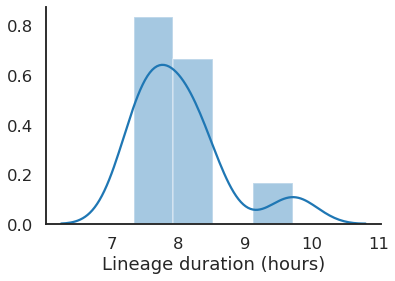

In [11]:
ax = sns.distplot(sample_duration['dur_hours'])
ax.set(xlabel = 'Lineage duration (hours)')
sns.despine()

print('Duration: %0.2f-%0.2f hours (mean: %0.2f)' % (np.min(sample_duration['dur_hours']),
                                                     np.max(sample_duration['dur_hours']),
                                                     np.mean(sample_duration['dur_hours'])))

## Load family data

Helper functions:

In [12]:
def gsearch(*args): return glob.glob(opj(*args))
def str_extract(pattern, s): return re.search(pattern, s).group(0)
def int_extract(pattern, s): return int(str_extract(pattern, s))

def open_graph(f):
    with open(f) as handle:
        graph_data = json.load(handle)
    return nx.json_graph.node_link_graph(graph_data)


Color-code families:

['#471365', '#482475', '#463480', '#414487', '#3b528b', '#355f8d', '#2f6c8e', '#2a788e', '#25848e', '#21918c', '#1e9c89', '#22a884', '#2fb47c', '#44bf70', '#5ec962', '#7ad151', '#9bd93c', '#bddf26', '#dfe318']


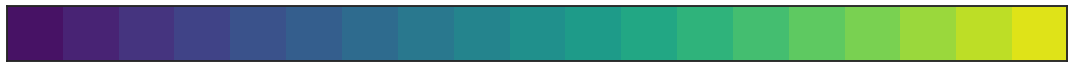

In [13]:
gen_pal = sns.color_palette('viridis', 19)
gen_hex = gen_pal.as_hex()

print(gen_hex)
sns.palplot(gen_pal)

Assign a generation # to each member of the sample families:

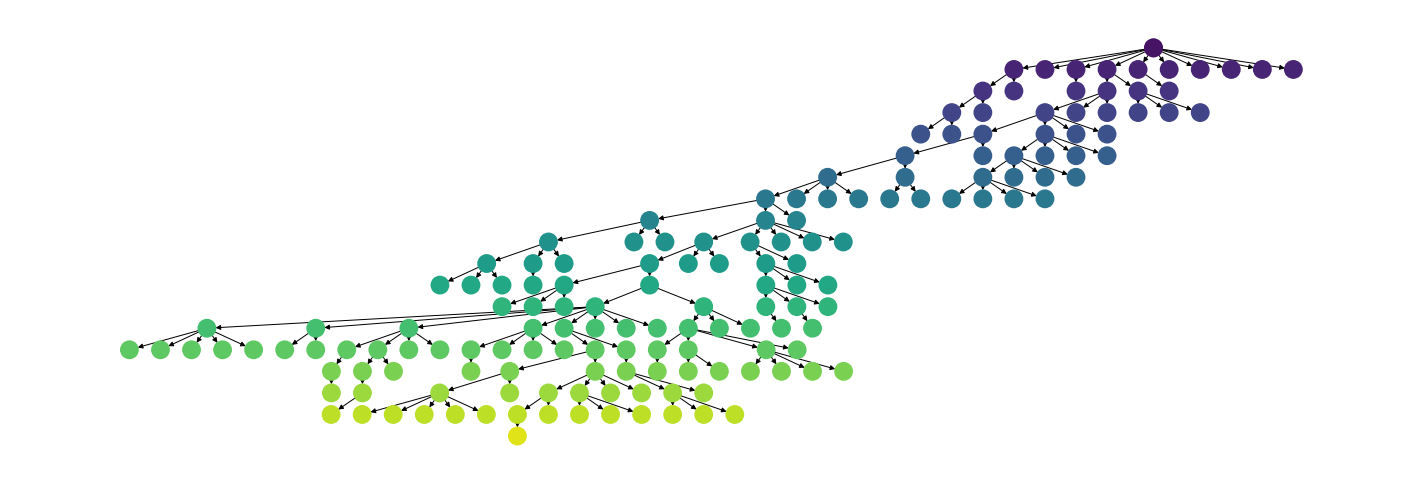

In [14]:
plot_kw = 'LOVE'
fam_template = 'outputs/families/families_%s.json'
generations_list = []

for fam in sample_families:
    # Load family tree
    fam_file = fam_template % fam
    fam_graph = open_graph(fam_file)

    # Compute distance from Eve to each relative
    eve = int_extract('(?<=eve-)([0-9]+)', fam_file)
    dist_dict = nx.single_source_shortest_path(fam_graph, eve)
    dist_list = [(fam, k, len(v)-1) for k,v in dist_dict.items()]
    dist_df = pd.DataFrame(dist_list, columns=['family', 'avatar', 'gen'])
    
    # Choose one of the sample families to plot
    if plot_kw in fam:
        # Plot layout
        nx.nx_agraph.write_dot(fam_graph,'fam.dot')
        pos=graphviz_layout(fam_graph, prog='dot')
        pos_coords = pd.DataFrame(list(pos.values()), columns=['x','y']).agg(['max', 'min'])
        w = (pos_coords.loc['max', 'x'] - pos_coords.loc['min', 'x'])/150
        h = (pos_coords.loc['max', 'y'] - pos_coords.loc['min', 'y'])/150
        
        # Draw plot
        plt.subplots(figsize=(w,h))
        fam_color = [gen_hex[len(dist_dict[int(n)])-1] for n in fam_graph.nodes]
        nx.draw(fam_graph, pos, with_labels=False, arrows=True, node_color=fam_color)
    
    generations_list.append(dist_df)

Save to dataframe:

In [15]:
generations = pd.concat(generations_list)
print(generations.shape)
generations.head()

(1435, 3)


,family,avatar,gen
0,time-1588091389_eve-2945499_name-LEBRASSEUR,2945499,0
1,time-1588091389_eve-2945499_name-LEBRASSEUR,2945519,1
2,time-1588091389_eve-2945499_name-LEBRASSEUR,2945500,1
3,time-1588091389_eve-2945499_name-LEBRASSEUR,2945559,2
4,time-1588091389_eve-2945499_name-LEBRASSEUR,2945547,2


## Plot start of each generation

Prepare dataframe of births:

In [16]:
# Get births
births_df = sample_lifelogs[['family', 'avatar', 'tBirth']]
births_df = births_df.sort_values(['family', 'tBirth'])
births_df = births_df.reset_index(drop=True)

# Timelock to Eve's birth
births_df['tEve'] =  births_df.groupby('family')['tBirth'].transform('first') 
births_df['t'] = births_df['tBirth'] - births_df['tEve']

# Assign number to each family
births_df['family_idx'] = births_df['family'].astype('category').cat.codes
births_df['family_name'] = births_df['family'].str.extract('(?<=name-)([A-Z]+)')

# Family groups
fam_list = list(births_df.groupby(['family_idx', 'family_name']).groups)
fam_idx, fam_names = zip(*fam_list)

births_df = pd.merge(births_df, generations, on=['family', 'avatar'])
births_df.head(10)

,family,avatar,tBirth,tEve,t,family_idx,family_name,gen
0,time-1575807301_eve-2386784_name-KILIAN,2386784,1575807301,1575807301,0,0,KILIAN,0
1,time-1575807301_eve-2386784_name-KILIAN,2386785,1575807377,1575807301,76,0,KILIAN,1
2,time-1575807301_eve-2386784_name-KILIAN,2386793,1575807568,1575807301,267,0,KILIAN,1
3,time-1575807301_eve-2386784_name-KILIAN,2386813,1575807858,1575807301,557,0,KILIAN,1
4,time-1575807301_eve-2386784_name-KILIAN,2386856,1575808827,1575807301,1526,0,KILIAN,1
5,time-1575807301_eve-2386784_name-KILIAN,2386900,1575809884,1575807301,2583,0,KILIAN,2
6,time-1575807301_eve-2386784_name-KILIAN,2386916,1575810177,1575807301,2876,0,KILIAN,2
7,time-1575807301_eve-2386784_name-KILIAN,2386926,1575810344,1575807301,3043,0,KILIAN,2
8,time-1575807301_eve-2386784_name-KILIAN,2387014,1575812309,1575807301,5008,0,KILIAN,3
9,time-1575807301_eve-2386784_name-KILIAN,2387052,1575812703,1575807301,5402,0,KILIAN,3


Generations plot:

[Text(0.5, 0, 'Time (minutes)'),
 [Text(0.0, 0, '0'),
  Text(3600.0, 0, '60'),
  Text(7200.0, 0, '120'),
  Text(10800.0, 0, '180'),
  Text(14400.0, 0, '240'),
  Text(18000.0, 0, '300'),
  Text(21600.0, 0, '360'),
  Text(25200.0, 0, '420'),
  Text(28800.0, 0, '480'),
  Text(32400.0, 0, '540'),
  Text(36000.0, 0, '600')],
 [Text(0, 0, 'KILIAN'),
  Text(0, 1, 'LONGSTAFF'),
  Text(0, 2, 'LOVE'),
  Text(0, 3, 'WASSER'),
  Text(0, 4, 'BRAZIL'),
  Text(0, 5, 'BATMAN'),
  Text(0, 6, 'LOGAN'),
  Text(0, 7, 'LEBRASSEUR'),
  Text(0, 8, 'DEBOARD'),
  Text(0, 9, 'UNO')]]

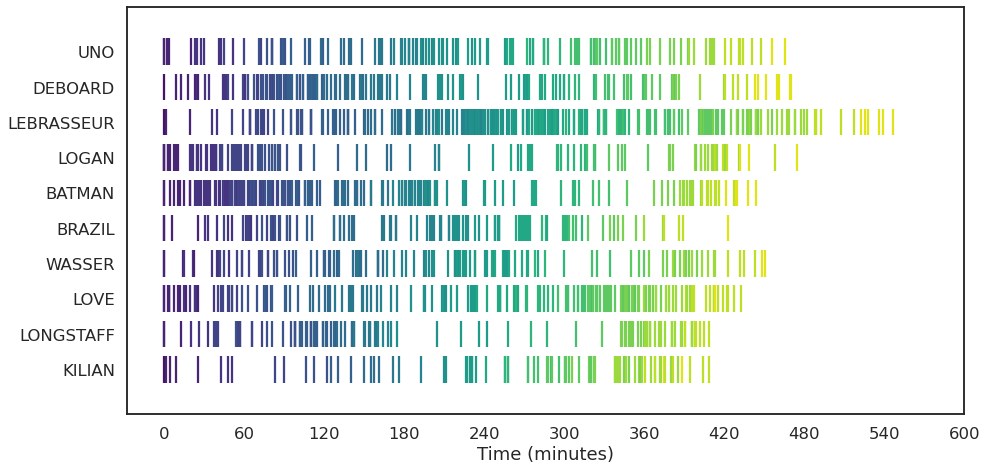

In [17]:
# Birth times
raster_data = births_df[['family_idx', 't']]
raster_data = raster_data.groupby('family_idx')['t'].apply(list).to_list()

# Generation colors
raster_colors =  births_df[['family_idx', 'gen']]
raster_colors = raster_colors.groupby('family_idx')['gen'].apply(list).to_list()
raster_colors = [[gen_hex[e] for e in l] for l in raster_colors]

fig, ax = plt.subplots(figsize = (15,7.5))
ax.eventplot(raster_data, linelengths = 0.75, colors = raster_colors)

# Aesthetics
xt = np.linspace(0,600,11)

ax.set(xlabel = 'Time (minutes)',
       xticks = xt*60,
       xticklabels = xt.astype(int),
       yticks = fam_idx,
       yticklabels = fam_names)

## Scale to all families

Get all family files:

In [18]:
all_families = success_df['family'].values
all_gen_list = []

for fam in notebook.tqdm(all_families):
    # Load family tree
    fam_file = fam_template % fam
    fam_graph = open_graph(fam_file)

    # Compute distance from Eve to each relative
    eve = int_extract('(?<=eve-)([0-9]+)', fam_file)
    dist_dict = nx.single_source_shortest_path(fam_graph, eve)
    dist_list = [(fam, k, len(v)-1) for k,v in dist_dict.items()]
    dist_df = pd.DataFrame(dist_list, columns=['family', 'avatar', 'gen'])
    
    all_gen_list.append(dist_df)

Save to dataframe:

In [19]:
all_generations = pd.concat(all_gen_list)
all_generations.to_csv('outputs/family_generations.tsv', sep='\t', index=False)

print(all_generations.shape)
all_generations.head()

(471336, 3)


,family,avatar,gen
0,time-1584155688_eve-2783193_name-JESUS,2783193,0
1,time-1584155688_eve-2783193_name-JESUS,2783246,1
2,time-1584155688_eve-2783193_name-JESUS,2783231,1
3,time-1584155688_eve-2783193_name-JESUS,2783221,1
4,time-1584155688_eve-2783193_name-JESUS,2783313,2


Intervals between generations:

In [20]:
gen_intervals = pd.merge(life_df, all_generations, on=['family', 'avatar'])

gen_intervals = gen_intervals.groupby(['family', 'gen'])['tBirth'].agg('min').reset_index()
gen_intervals['last_gen'] = gen_intervals.groupby('family')['tBirth'].shift(1)
gen_intervals['lag_min'] = (gen_intervals['tBirth'] - gen_intervals['last_gen'])/60

gen_intervals = gen_intervals.dropna()
gen_intervals = gen_intervals[gen_intervals['lag_min'] < 60]
gen_intervals['last_gen'] = gen_intervals['last_gen'].astype(int)

print(gen_intervals.shape)
gen_intervals.head()

(58105, 5)


,family,gen,tBirth,last_gen,lag_min
1,time-1573253679_eve-2251043_name-MCCRACKEN,1,1573253683,1573253679,0.066667
2,time-1573253679_eve-2251043_name-MCCRACKEN,2,1573254532,1573253683,14.150000
4,time-1573253705_eve-2251049_name-FINCH,1,1573253707,1573253705,0.033333
6,time-1573253707_eve-2251051_name-SORROWS,1,1573253857,1573253707,2.500000
8,time-1573253710_eve-2251053_name-LION,1,1573253744,1573253710,0.566667


Min: 0.00
Max: 59.98
Mean: 23.98
Median: 22.70


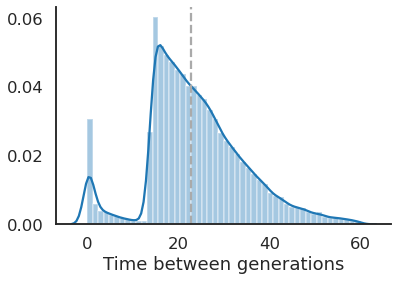

In [21]:
med_lag =  np.median(gen_intervals['lag_min'])
print('Min: %0.2f' % np.min(gen_intervals['lag_min']))
print('Max: %0.2f' % np.max(gen_intervals['lag_min']))
print('Mean: %0.2f' % np.mean(gen_intervals['lag_min']))
print('Median: %0.2f' % med_lag)

ax = sns.distplot(gen_intervals['lag_min'])
plt.axvline(med_lag, color='#aaaaaa', linestyle='--')
ax.set(xlabel = 'Time between generations')
sns.despine()